In [1]:
import numpy as np
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

# Anomaly detection

In [2]:
data1 = scipy.io.loadmat('data/ex8data1.mat')

X = data1['X']
Xval = data1['Xval']
yval = data1['yval']

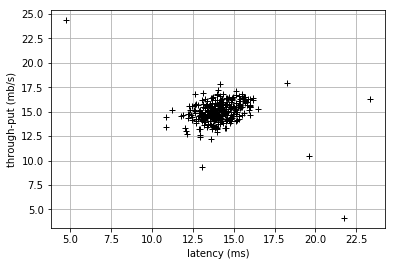

In [3]:
plt.plot(X[:,0], X[:,1], 'k+')
plt.ylabel('through-put (mb/s)' )
plt.xlabel('latency (ms)')
plt.grid(True)

### Estimating parameters for a Gaussian

In [4]:
def estimate_gaus_param(X, multivar=False):
    mean = np.mean(X, axis=0)
    
    if multivar:
        cov = 1/float(len(X)) * np.dot( (X - mean).T , X-mean)
    else:
        cov = np.diag(np.var(X, axis=0))
    return mean,cov

def plot_contours(X, mean, cov):
    
    X1range = np.arange(np.min(X[:,0]),np.max(X[:,0]),0.5)
    X2range = np.arange(np.min(X[:,1]),np.max(X[:,1]),0.5)

    X1mesh, X2mesh = np.meshgrid(X1range, X2range)
    
    coord_list = [ np.array([X0,X1]) for X0, X1 in zip(np.ravel(X1mesh), np.ravel(X2mesh)) ]
    Z = multivariate_normal.pdf( coord_list , mean=mean, cov=cov)
    Z = Z.reshape(X1mesh.shape)
    
    cont_levels = [10**exp for exp in range(-50,0,3)]
    
    cs = plt.contour(X1mesh, X2mesh, Z, 10, levels=cont_levels)

    plt.clabel(cs, fmt='%g', inline=1, fontsize=10)
    

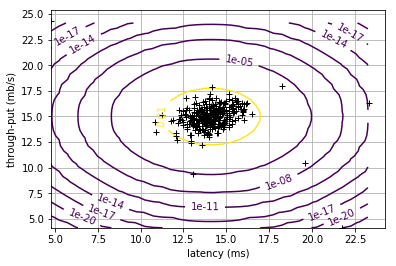

In [5]:
plt.plot(X[:,0], X[:,1], 'k+')
plt.ylabel('through-put (mb/s)' )
plt.xlabel('latency (ms)')
plt.grid(True)
mu, cov = estimate_gaus_param(X,False)
plot_contours(X, mu, cov)

### Selecting the threshold, ε

In [6]:
def select_treshold(Pval,yval, nsteps=1000):
    
    epses = np.linspace(np.min(Pval),np.max(Pval),nsteps)
    bestF1, bestEps = 0, 0

    # P (precision) : fraction of true positive over total estmated
    # R (recall) : fraction of true positive over total positive
    #
    # given pred and y as boolean arrays    
    #
    # P = TP / ( TP + FP) ==> (TP + FP) == np.sum(pred) 
    # R = TP / ( TP + FN) ==> (TP + FN) == np.sum(y) 

    for e in epses: 
        
        pred = Pval < e
    
        P = np.sum([int(pred[i]) for i in xrange(len(pred)) if yval[i]]) / float( np.sum(pred))
        R = np.sum([int(pred[i]) for i in xrange(len(pred)) if yval[i]]) / float( np.sum(yval))

        F1 = (2*P*R)/(P+R)
        
        if F1 > bestF1:
            bestF1,bestEps = F1,e
        
    print "Best F1 is %.3f, best eps is %.5g."%(bestF1,bestEps)
    return bestEps,bestF1

In [7]:
mu, cov = estimate_gaus_param(X,False)
Pval = multivariate_normal.pdf( Xval, mean=mu, cov=cov)
Eps,F1 = select_treshold(Pval, yval)

Best F1 is 0.875, best eps is 8.9999e-05.


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


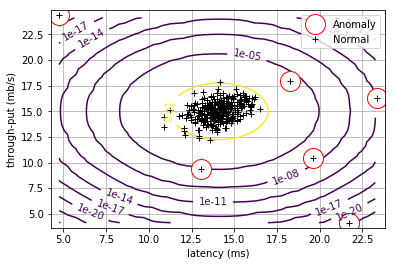

In [8]:
Anomalies = multivariate_normal.pdf( X, mean=mu, cov=cov) < Eps
plt.plot(X[Anomalies,0 ], X[Anomalies,1], 'wo', mec='r', markersize=20, label='Anomaly')
plt.plot(X[:,0], X[:,1], 'k+', label='Normal')
plt.ylabel('through-put (mb/s)' )
plt.xlabel('latency (ms)')
plt.grid(True)
mu, cov = estimate_gaus_param(X,False)
plot_contours(X, mu, cov)
plt.xlim(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5)
plt.ylim(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5)
plt.legend()

### High dimensional dataset

In [9]:
data2 = scipy.io.loadmat('data/ex8data2.mat')
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']

In [10]:
X.shape

(1000, 11)

In [11]:
mu, cov = estimate_gaus_param(X,False)
Pval = multivariate_normal.pdf( Xval, mean=mu, cov=cov)
Eps,F1 = select_treshold(Pval, yval)
Anomalies = multivariate_normal.pdf( X, mean=mu, cov=cov) < Eps

print "Anomalies found: %d" % Anomalies.sum()

Best F1 is 0.615, best eps is 1.3786e-18.
Anomalies found: 117


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


# Reccomender systems

In [12]:
import re
movie_ratings = scipy.io.loadmat('data/ex8_movies.mat')
R = movie_ratings['R'] # movies index, user index
Y = movie_ratings['Y'] # movies index, user index

titles = [re.sub('^[0-9]+\ ', '', titles.rstrip('\n')) for titles in open('data/movie_ids.txt')] 
    
print Y.shape

(1682, 943)


### Compute the average movie rating for the first movie

In [13]:
m1 = np.mean([ Y[:1, i] for i in xrange(Y.shape[1]) if R[:1, i]])
print "Average rating for \"%s\": %.2f" % (titles[0], m1)

Average rating for "Toy Story (1995)": 3.88


### Collaborative filtering learning algorithm

In [14]:
movie_params = scipy.io.loadmat('data/ex8_movieParams.mat')
X = movie_params['X'] # movies index, user index
Theta = movie_params['Theta'] # movies index, user index

In [15]:
print 'X', X.shape
print 'Theta', Theta.shape
print 'Y', Y.shape
print 'R', R.shape

X (1682, 10)
Theta (943, 10)
Y (1682, 943)
R (1682, 943)


In [16]:
def cost(X,Theta,Y,R, Lambda = 0):
    
    cost = np.square(np.dot(X,Theta.T) - Y)
    cost = np.multiply(cost,R)
    cost = np.sum(cost)
    
    cost += Lambda * np.sum( np.square(X) )
    cost += Lambda * np.sum( np.square(Theta) )
    cost *= 0.5

    return cost

In [17]:
Nm,Nu,Nf = 5,4,3
print "Cost function for (Nm,Nu,Nf) = (%d,%d,%d) w/o regularization : %.2f" % (Nm,Nu,Nf,cost(X[:Nm,:Nf],Theta[:Nu,:Nf],Y[:Nm,:Nu],R[:Nm,:Nu]))
print "Cost function for (Nm,Nu,Nf) = (%d,%d,%d) w/  regularization : %.2f" % (Nm,Nu,Nf,cost(X[:Nm,:Nf],Theta[:Nu,:Nf],Y[:Nm,:Nu],R[:Nm,:Nu],1.5))

Cost function for (Nm,Nu,Nf) = (5,4,3) w/o regularization : 22.22
Cost function for (Nm,Nu,Nf) = (5,4,3) w/  regularization : 31.34


In [18]:
def grad(X,Theta,Y,R, Lambda = 0.):
    
    gradX = np.dot(X,Theta.T) - Y # Nm, Nu
    gradX = np.multiply(gradX,R) # Nm, Nu
    gradX = np.dot(gradX,Theta) # Nm, Nf
    gradX += Lambda * X
    
    gradT = np.dot(X,Theta.T) - Y # Nm, Nu
    gradT = np.multiply(gradT,R) # Nm, Nu
    gradT = np.dot(gradT.T,X) # Nu, Nf
    gradT += Lambda * Theta

    return np.concatenate( (gradX.flatten(), gradT.flatten()), axis=0)

def grad_check(X,Theta,Y,R, Lambda = 0.):
    
    mygrad = grad(X,Theta,Y,R, Lambda)
    
    params = np.concatenate( (X.flatten(), Theta.flatten()), axis=0)
    
    eps = 0.0001
    epsVec = np.zeros(len(params))
    
    for i in xrange(10):
        idx = np.random.randint(0,len(params))
        epsVec[idx] = eps
        
        param1 = params-epsVec
        reX = param1[:int(X.shape[0]*X.shape[1])].reshape((X.shape[0],X.shape[1]))
        reTheta = param1[int(X.shape[0]*X.shape[1]):].reshape((Theta.shape[0],Theta.shape[1]))
        loss1 = cost(reX,reTheta,Y,R, Lambda)

        param2 = params+epsVec
        reX = param2[:int(X.shape[0]*X.shape[1])].reshape((X.shape[0],X.shape[1]))
        reTheta = param2[int(X.shape[0]*X.shape[1]):].reshape((Theta.shape[0],Theta.shape[1]))
        loss2 = cost(reX,reTheta,Y,R, Lambda)

        numgrad = (loss2-loss1)/ (2*eps)
        epsVec[idx] = 0
        
        print "%.15f \t %.15f \t %.15f" % (mygrad[idx], numgrad, mygrad[idx] - numgrad)

In [19]:
print "Check gradient with Lambda = 0."
grad_check(X[:Nm,:Nf],Theta[:Nu,:Nf],Y[:Nm,:Nu],R[:Nm,:Nu])
print ""
print "Check gradient with Lambda = 1.5"
grad_check(X[:Nm,:Nf],Theta[:Nu,:Nf],Y[:Nm,:Nu],R[:Nm,:Nu], 1.5)

Check gradient with Lambda = 0.
-0.803780061452057 	 -0.803780061460202 	 0.000000000008145
-0.803780061452057 	 -0.803780061460202 	 0.000000000008145
-0.353340482875070 	 -0.353340482881492 	 0.000000000006423
0.000000000000000 	 0.000000000000000 	 0.000000000000000
4.627760190006159 	 4.627760190007990 	 -0.000000000001831
7.575703079709334 	 7.575703079698570 	 0.000000000010764
0.000000000000000 	 0.000000000000000 	 0.000000000000000
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-0.568195965515757 	 -0.568195965513496 	 -0.000000000002261
0.000000000000000 	 0.000000000000000 	 0.000000000000000

Check gradient with Lambda = 1.5
-2.997914223943359 	 -2.997914223907827 	 -0.000000000035532
6.975355139747124 	 6.975355139733352 	 0.000000000013771
-0.892473343597432 	 -0.892473343601097 	 0.000000000003664
0.129856157163688 	 0.129856157169428 	 -0.000000000005740
1.092897577688307 	 1.092897577699148 	 -0.000000000010841
-0.647874841514519 	 -0.647874841526175 	 0.000

### Learning movie recommendations

In [25]:
# need  to write interface for flatten parameters...

def reshape(XT_flat,X_shape,T_shape):
    reX = XT_flat[:int(X_shape[0]*X_shape[1])].reshape(X_shape)
    reTheta = XT_flat[int(X_shape[0]*X_shape[1]):].reshape((T_shape[0],T_shape[1]))
    return reX,reTheta

def flat_cost(XT_flat,X_shape,T_shape,Y,R,Lambda = 0.):
    reX, reTheta = reshape(XT_flat,X_shape,T_shape)
    return cost(reX,reTheta,Y,R,Lambda)

def flat_grad(XT_flat,X_shape,T_shape,Y,R,Lambda = 0.):
    reX, reTheta = reshape(XT_flat,X_shape,T_shape) 
    return grad(reX,reTheta,Y,R,Lambda)

In [101]:
# Add an additional user with his rating
# (Taken from the excercise)
myY = np.zeros((1682,1))
myY[0]   = 4
myY[97]  = 2
myY[6]   = 3
myY[11]  = 5
myY[53]  = 4
myY[63]  = 5
myY[65]  = 3
myY[68]  = 5
myY[182] = 4
myY[225] = 5
myY[354] = 5

myR = myY > 0

# Stack the new user's rating onto the dataset
newY = np.hstack((Y,myY))
newR = np.hstack((R,myR))
nm, nu = newY.shape

# Normalise user ratings, counting only movies that have actually been rated!
meanY = np.sum(newY, axis=1) / np.sum(newR, axis=1)
meanY = meanY.reshape((meanY.shape[0],1))
newNormY = newY - meanY 

print "\nOriginal ratings provided:"
for i in xrange(len(myY)):
    if myY[i] > 0:
        print 'Rated %d for movie %s.' % (myY[i],titles[i])


Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects, The (1995).
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption, The (1994).
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs, The (1991).
Rated 4 for movie Alien (1979).
Rated 5 for movie Die Hard 2 (1990).
Rated 5 for movie Sphere (1998).


In [103]:
# initialise random user parameters and movies features
# use 10 movies features
newX = np.random.rand( nm, 10)
newTheta = np.random.rand(nu, 10)

#flatten parameters
XT_flat = np.concatenate( (newX.flatten(), newTheta.flatten()), axis=0)

# Regularization parameter of 10 is used (as used in the homework assignment)
Lambda = 10.

# Training
result = scipy.optimize.fmin_cg(flat_cost, x0=XT_flat, fprime=flat_grad, 
                                args=(newX.shape,newTheta.shape,newNormY,newR,Lambda),
                                maxiter=100,disp=True,full_output=True)

         Current function value: 38956.240387
         Iterations: 100
         Function evaluations: 146
         Gradient evaluations: 146


In [104]:
newX,newTheta = reshape(result[0],newX.shape,newTheta.shape)

In [105]:
# compute the prediction matrix
pred = np.dot(newX, newTheta.T)
pred = pred + meanY

In [106]:
my_pred = pred[:,-1]# + meanY.flatten()
my_pred_idxs_sorted = np.argsort(my_pred)
my_pred_idxs_sorted = my_pred_idxs_sorted[::-1]

In [107]:
print "Top recommendations for you:"
for i in xrange(20):
    print 'Predicting rating %0.1f for movie %s.' % \
    (my_pred[my_pred_idxs_sorted[i]],titles[my_pred_idxs_sorted[i]])

Top recommendations for you:
Predicting rating 5.0 for movie Great Day in Harlem, A (1994).
Predicting rating 5.0 for movie They Made Me a Criminal (1939).
Predicting rating 5.0 for movie Prefontaine (1997).
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993).
Predicting rating 5.0 for movie Santa with Muscles (1996).
Predicting rating 5.0 for movie Someone Else's America (1995).
Predicting rating 5.0 for movie Star Kid (1997).
Predicting rating 5.0 for movie Aiqing wansui (1994).
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicting rating 4.6 for movie Pather Panchali (1955).
Predicting rating 4.5 for movie Shawshank Redemption, The (1994).
Predicting rating 4.5 for movie Star Wars (1977).
Predicting rating 4.5 for movie Wrong Trousers, The (1993).
Predicting rating 4.5 for movie Maya Lin: A Strong Clear Vision (1994).
Predicting rating 4.5 for movie An